In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn import svm
import cv2

# Toggle between grayscale and RGB input
use_rgb = True
image_size = (64, 64)
input_channels = 3 if use_rgb else 1
input_size = image_size[0] * image_size[1] * input_channels

# Load images and labels
def load_images_from_folder(folder, label, use_rgb):
    images = []
    labels = []
    for filename in os.listdir(folder):
        flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
        img = cv2.imread(os.path.join(folder, filename), flag)
        if img is not None:
            img = cv2.resize(img, image_size)
            if use_rgb:
                img = img.transpose((2, 0, 1)).reshape(-1)  # HWC to CHW then flatten
            else:
                img = img.flatten()
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

pleasant_images, pleasant_labels = load_images_from_folder('train-images/train/pleasant', 1, use_rgb)
unpleasant_images, unpleasant_labels = load_images_from_folder('train-images/train/unpleasant', 0, use_rgb)

X = np.array(pleasant_images + unpleasant_images, dtype=np.float32)
y = np.array(pleasant_labels + unpleasant_labels, dtype=np.int64)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Training SVM with kernel=linear, C=0.1
Accuracy: 0.8275862068965517
Precision: 0.8470764617691154
Recall: 0.8272327964860908
F1 Score: 0.837037037037037
Confusion Matrix:
 [[491 102]
 [118 565]]
Training SVM with kernel=linear, C=1
Accuracy: 0.8072100313479624
Precision: 0.8237037037037037
Recall: 0.8140556368960469
F1 Score: 0.8188512518409425
Confusion Matrix:
 [[474 119]
 [127 556]]
Training SVM with kernel=linear, C=10
Accuracy: 0.8072100313479624
Precision: 0.8237037037037037
Recall: 0.8140556368960469
F1 Score: 0.8188512518409425
Confusion Matrix:
 [[474 119]
 [127 556]]
Training SVM with kernel=linear, C=100
Accuracy: 0.8072100313479624
Precision: 0.8237037037037037
Recall: 0.8140556368960469
F1 Score: 0.8188512518409425
Confusion Matrix:
 [[474 119]
 [127 556]]
Training SVM with kernel=rbf, C=0.1
Accuracy: 0.8181818181818182
Precision: 0.8764607679465777
Recall: 0.7686676427525623
F1 Score: 0.8190327613104524
Confusion Matrix:
 [[519  74]
 [158 525]]
Training SVM with kernel=rb

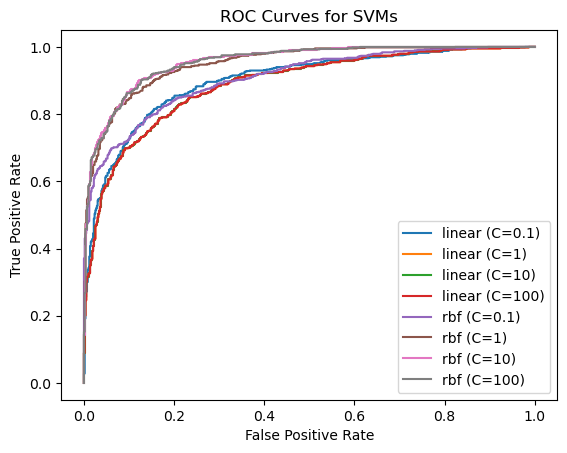

In [2]:
# Train SVM classifiers with different kernels and C values
kernels = ['linear', 'rbf']  # cosine not supported directly, would require custom kernel
C_values = [0.1, 1, 10, 100]
f1max = 0

for kernel in kernels:
    for C in C_values:
        print(f"Training SVM with kernel={kernel}, C={C}")
        clf = svm.SVC(kernel=kernel, C=C, probability=True)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)
        y_proba = clf.predict_proba(X_val)[:, 1]

        print("Accuracy:", accuracy_score(y_val, y_pred))
        print("Precision:", precision_score(y_val, y_pred))
        print("Recall:", recall_score(y_val, y_pred))
        print("F1 Score:", f1_score(y_val, y_pred))
        if f1max == 0:
            f1max = f1_score(y_val, y_pred)
            kernelmax = kernel
            cvaluemax = C
        else:
            if f1max < f1_score(y_val, y_pred):
                f1max = f1_score(y_val, y_pred)
                kernelmax = kernel
                cvaluemax = C
        print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'{kernel} (C={C})')
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVMs')
plt.legend()
plt.show()

In [ ]:
# Choose best model
final_model = svm.SVC(kernel=kernelmax, C=cvaluemax, probability=True)
final_model.fit(X_train, y_train)

# Predict test set
test_df = pd.read_csv('Test-IDs.csv')
submission = []

for _, row in test_df.iterrows():
    img_path = os.path.join('TEST_images/TEST_images', row['Filename'])
    flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, flag)
    if img is not None:
        img = cv2.resize(img, image_size)
        if use_rgb:
            img = img.transpose((2, 0, 1)).reshape(-1)
        else:
            img = img.flatten()
        img = img / 255.0
        pred = final_model.predict([img])[0]
        submission.append({'ID': row['ID'], 'LABEL': int(pred)})

submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved with SVM predictions.")